In [7]:
from torchvision import transforms
import torch
import PIL.Image as Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

import sys
import os
sys.path.append('../src') 
import models_src


# Performs one_hot_encoding for tensor containing probabilities of the form (N, C, H, W)
def one_hot_encoded(probs):
    # Step 1: Get predicted class indices (N, H, W)
    class_indices = probs.argmax(dim=1)  # class with max prob per pixel
    # Step 2: One-hot encode the class indices to (N, H, W, C)
    one_hot = F.one_hot(class_indices, num_classes=probs.shape[1])
    # Step 3: Permute to (N, C, H, W) to match original tensor shape
    one_hot = one_hot.permute(0, 3, 1, 2).float()
    return one_hot

In [16]:
# Important paths
save_dir = '/Users/sushmitachandel/Desktop/portfolio_of_projects/detection_of_ocean_features_DL/autoencoder/models/train3'
checkpoint_path = f"{save_dir}/bestepoch.pth" # path of the best model to load

labels = ['AF', 'BS', 'I', 'LWA', 'MCC', 'OF', 'POW', 'RC', 'SI', 'WS', 'BG']

# Load the model
device = 'mps'
model = models_src.Autoencoder()
model = model.to(device)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Define the transform.
val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.2289],
                     [0.0396])
    ])

/var/folders/b8/rtv5tv_d33d2cdm2hp_l2wwm0000gn/T/ipykernel_92446/4055489446.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map

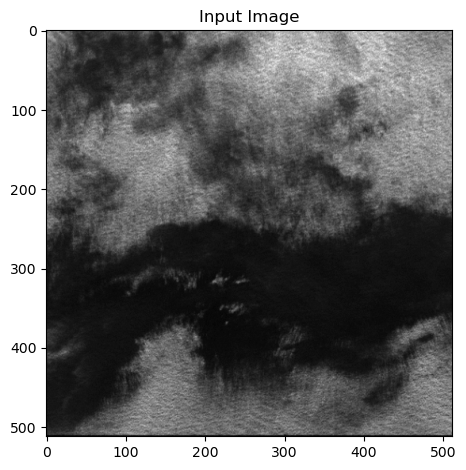

Predictions class-wise


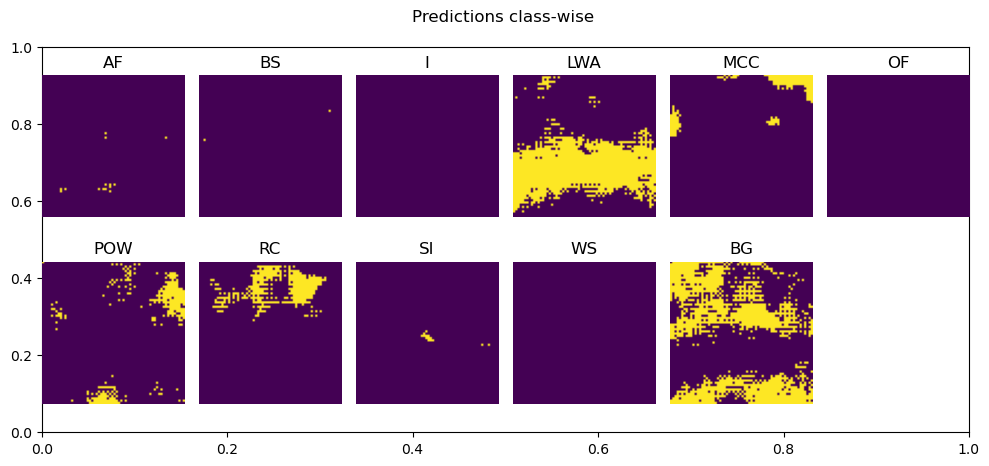

Ground Truth labels class-wise


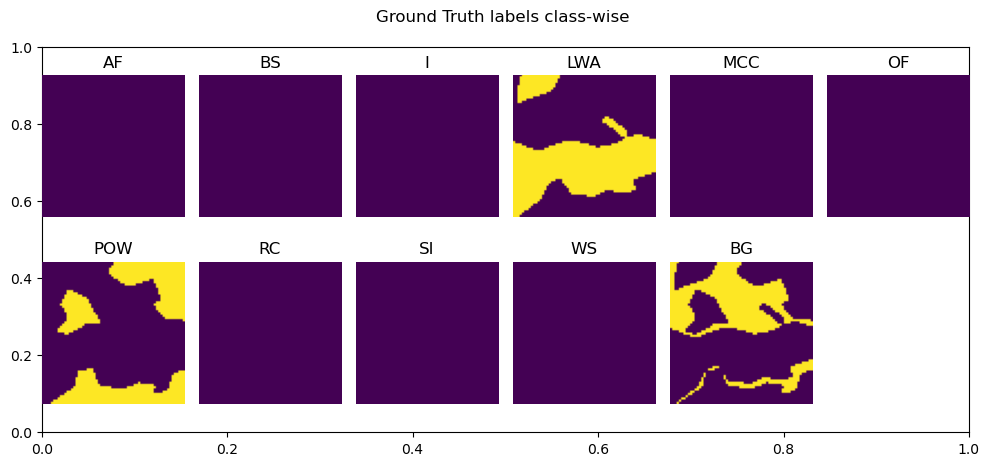

In [38]:
image_path = '/Users/sushmitachandel/Desktop/dataset/ocean_features_pixel_level/archive/test/input/s1a-wv1-slc-vv-20161004t015217-20161004t015220-013333-01542f-095.png'
label_path = '/Users/sushmitachandel/Desktop/dataset/ocean_features_pixel_level/archive/test/output/s1a-wv1-slc-vv-20161004t015217-20161004t015220-013333-01542f-095.npy'

# Read the image and then transform it
sample_img = Image.open(image_path)
sample_img_transform = val_transforms(sample_img) # (1, 256, 256)

# Read the ground truth and convert suitable so that it has only 0s and 1s.
# This needs to be done only for test ground truths. Train and val alread are in
# the correct format
label_img = np.load(label_path) # (64, 64, 10)

if len(np.unique(label_img)) > 2:
    label_img[label_img<=125] = 0
    label_img[label_img>125] = 255
# Add baclground pixels as a seperate class.
label_img = torch.from_numpy(label_img).float() # (64, 64, 10)
label_img = label_img.permute(2,0,1)
background_mask = (label_img.sum(dim=0) == 0).float()
background_channel = background_mask.unsqueeze(0)
label_new = torch.cat([label_img,background_channel], dim = 0)


# Predict
with torch.no_grad():
    sample_img_pred = sample_img_transform.unsqueeze(0).to(device)
    output = model(sample_img_pred) # (1, 11, 64, 64)
    output_softmax = F.softmax(output, dim=1) # (1, 11, 64, 64)
    outputs_onehot = one_hot_encoded(output_softmax) # (1, 11, 64, 64)
    output = outputs_onehot.detach().cpu().numpy()
    output = output[0]

# Display 
plt.imshow(sample_img, cmap='gray')
plt.title('Input Image')
plt.tight_layout()
plt.show()
# plt.close()

print('Predictions class-wise')
plt.figure(figsize=(10, 4.7))
plt.title('Predictions class-wise \n')
for i_label, label in enumerate(labels):
    plt.subplot(2, 6, i_label + 1)
    plt.imshow(output[i_label,:,:], vmin=0, vmax=1)
    plt.axis('off')
    plt.title(label)
plt.tight_layout()
plt.show()
plt.close()

# print(label_new.shape)
print('Ground Truth labels class-wise')

plt.figure(figsize=(10, 4.7))
plt.title('Ground Truth labels class-wise \n')
for i_label, label in enumerate(labels):
    plt.subplot(2, 6, i_label + 1)
    plt.imshow(label_new[i_label,:,:], vmin=0, vmax=1)
    plt.axis('off')
    plt.title(label)
plt.tight_layout()
plt.show()
plt.close()

float32


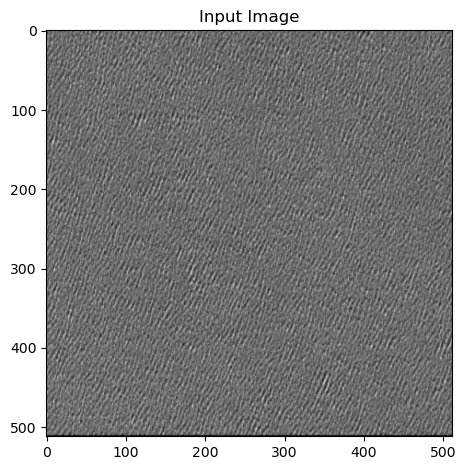

float32
Predictions class-wise


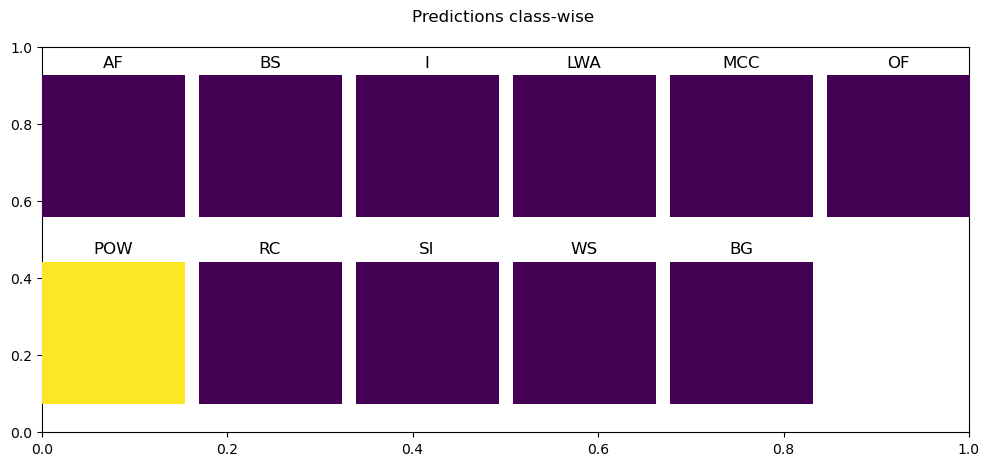

Ground Truth labels class-wise


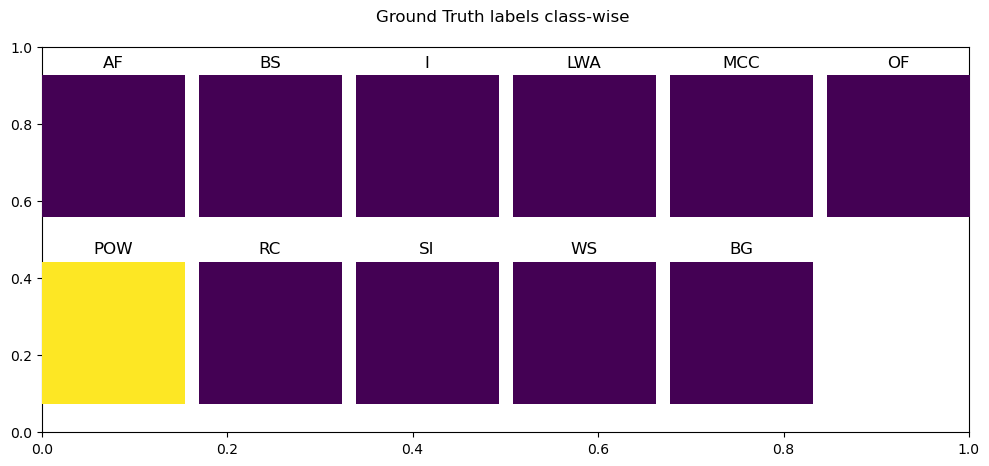

In [39]:
image_path = '/Users/sushmitachandel/Desktop/dataset/ocean_features_pixel_level/archive/test/input/s1a-wv1-slc-vv-20160103t120707-20160103t120710-009329-00d7c8-011.png'
label_path = '/Users/sushmitachandel/Desktop/dataset/ocean_features_pixel_level/archive/test/output/s1a-wv1-slc-vv-20160103t120707-20160103t120710-009329-00d7c8-011.npy'

# Read the image and then transform it
sample_img = Image.open(image_path)
sample_img_transform = val_transforms(sample_img) # (1, 256, 256)

# Read the ground truth and convert suitable so that it has only 0s and 1s.
# This needs to be done only for test ground truths. Train and val alread are in
# the correct format
label_img = np.load(label_path) # (64, 64, 10)
if len(np.unique(label_img)) > 2:
    label_img[label_img<=125] = 0
    label_img[label_img>125] = 255
# Add baclground pixels as a seperate class.
label_img = torch.from_numpy(label_img).float() # (64, 64, 10)
label_img = label_img.permute(2,0,1)
background_mask = (label_img.sum(dim=0) == 0).float()
background_channel = background_mask.unsqueeze(0)
label_new = torch.cat([label_img,background_channel], dim = 0)
label_new = label_new.detach().cpu().numpy()
print(label_new.dtype)
# Predict
with torch.no_grad():
    sample_img_pred = sample_img_transform.unsqueeze(0).to(device)
    output = model(sample_img_pred) # (1, 11, 64, 64)
    output_softmax = F.softmax(output, dim=1) # (1, 11, 64, 64)
    outputs_onehot = one_hot_encoded(output_softmax) # (1, 11, 64, 64)
    output = outputs_onehot.detach().cpu().numpy()
    output = output[0]

# Display 
plt.imshow(sample_img, cmap='gray')
plt.title('Input Image')
plt.tight_layout()
plt.show()
# plt.close()

print(output.dtype)
print('Predictions class-wise')
plt.figure(figsize=(10, 4.7))
plt.title('Predictions class-wise \n')
for i_label, label in enumerate(labels):
    plt.subplot(2, 6, i_label + 1)
    plt.imshow(output[i_label,:,:], vmin=0, vmax=1)
    # print(output[i_label,:,:].dtype)
    plt.axis('off')
    plt.title(label)
plt.tight_layout()
plt.show()
plt.close()

# print(label_new.shape)
print('Ground Truth labels class-wise')
plt.figure(figsize=(10, 4.7))
plt.title('Ground Truth labels class-wise \n')
for i_label, label in enumerate(labels):
    plt.subplot(2, 6, i_label + 1)
    # plt.imshow(label_img[:,:,i_label], vmin=0, vmax=1)
    plt.imshow(label_new[i_label,:,:], vmin=0, vmax=1)
    plt.axis('off')
    plt.title(label)
plt.tight_layout()
plt.show()
plt.close()